# 2D LWR Solver — API Test Notebook

Interactive tests for the `numerical_solvers.lwr2d` public API:
- Initial condition builders: `riemann_x`, `riemann_y`, `four_quadrant`, `gaussian_bump`, `random_piecewise`
- Solvers: `generate_one`, `generate_n`
- Physics: Greenshields flux $f(\rho) = v_{\max} \rho (1 - \rho / \rho_{\max})$

**PDE**: $\partial_t \rho + \partial_x f(\rho) + \partial_y g(\rho) = 0$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import Normalize

from numerical_solvers.lwr2d import (
    cfl_dt,
    four_quadrant,
    gaussian_bump,
    generate_n,
    generate_one,
    riemann_x,
    riemann_y,
)
from numerical_solvers.lwr2d.physics import (
    greenshields_derivative,
    greenshields_flux,
    triangular_flux,
)

%matplotlib inline

# Shared grid parameters
NX, NY = 80, 80
DX = DY = 1.0 / NX
V_MAX = 1.0
RHO_MAX = 1.0
DT = cfl_dt(DX, DY, V_MAX, V_MAX, cfl_number=0.45)
NT = 200

x = torch.arange(NX, dtype=torch.float32) * DX
y = torch.arange(NY, dtype=torch.float32) * DY

print(f"Grid: {NX}x{NY}, dx=dy={DX:.4f}, dt={DT:.6f}, nt={NT}")
print(f"Final time T = {NT * DT:.4f}")


def plot_snapshots(rho, x, y, t, title, snap_indices=None, vmin=0.0, vmax=1.0):
    """Plot 2D density snapshots at selected time indices."""
    if snap_indices is None:
        nt = rho.shape[0] - 1
        snap_indices = [0, nt // 4, nt // 2, nt]
    n_snaps = len(snap_indices)
    fig, axes = plt.subplots(1, n_snaps, figsize=(4 * n_snaps, 3.5))
    if n_snaps == 1:
        axes = [axes]
    norm = Normalize(vmin=vmin, vmax=vmax)
    for ax, idx in zip(axes, snap_indices, strict=False):
        im = ax.imshow(
            rho[idx].numpy(),
            origin="lower",
            extent=[x[0].item(), x[-1].item() + DX, y[0].item(), y[-1].item() + DY],
            cmap="viridis",
            norm=norm,
            aspect="equal",
        )
        ax.set_title(f"t = {t[idx]:.4f}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    fig.suptitle(title, fontsize=14)
    fig.colorbar(im, ax=axes, shrink=0.8, label=r"$\rho$")
    fig.tight_layout()
    plt.show()

Grid: 80x80, dx=dy=0.0125, dt=0.002812, nt=200
Final time T = 0.5625


## 1. Four-Quadrant Riemann Problem

/tmp/ipykernel_34353/1719190479.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


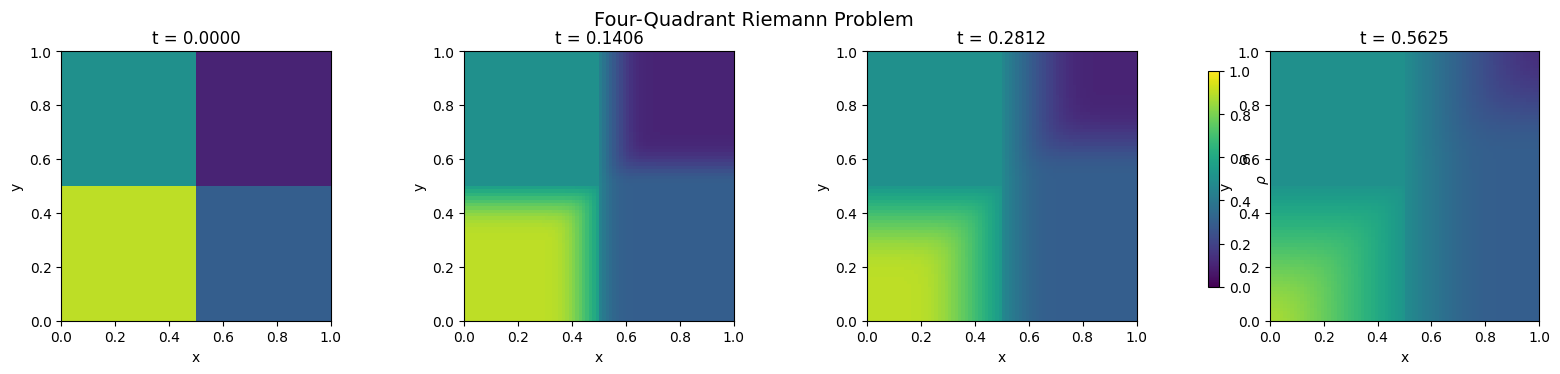

rho shape: torch.Size([201, 80, 80])


In [2]:
rho0 = four_quadrant(x, y, rho_bl=0.9, rho_br=0.3, rho_tl=0.5, rho_tr=0.1)
sol = generate_one(rho0, dx=DX, dy=DY, dt=DT, nt=NT, bc_type="zero_gradient")

plot_snapshots(
    sol["rho"], sol["x"], sol["y"], sol["t"], "Four-Quadrant Riemann Problem"
)
print(f"rho shape: {sol['rho'].shape}")

## 2. x-Riemann Problem (Uniform in y)

/tmp/ipykernel_34353/1719190479.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


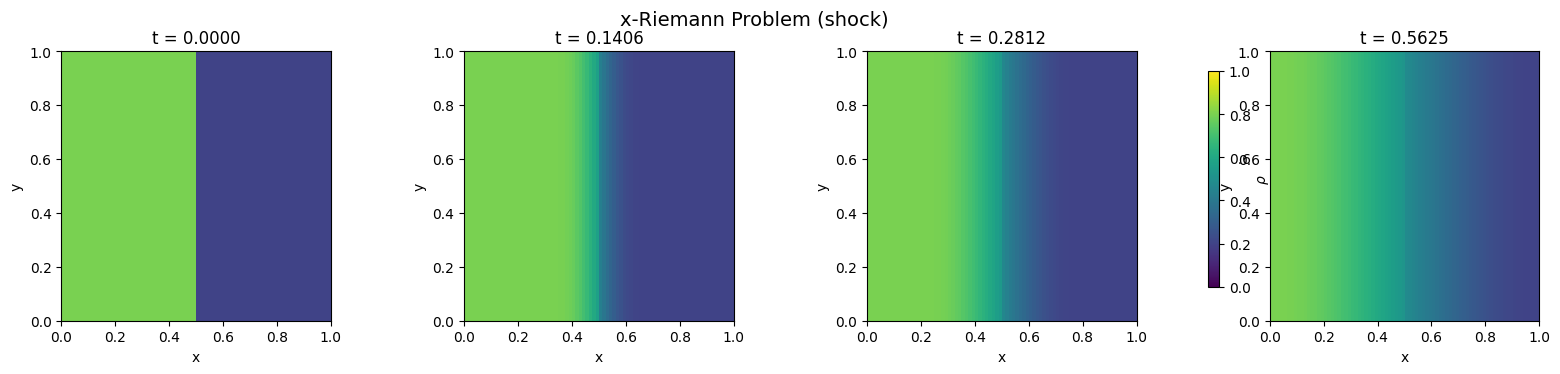

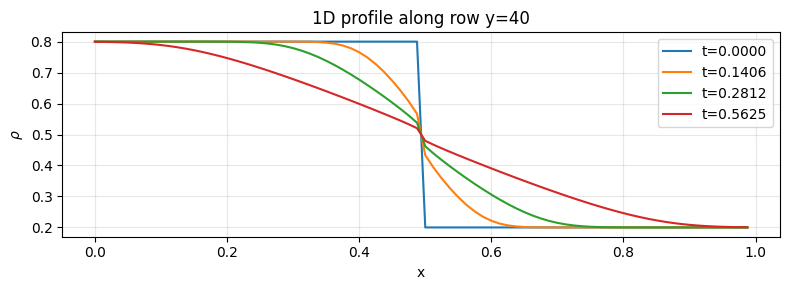

In [3]:
rho0_xr = riemann_x(x, y, rho_left=0.8, rho_right=0.2)
sol_xr = generate_one(rho0_xr, dx=DX, dy=DY, dt=DT, nt=NT, bc_type="zero_gradient")

plot_snapshots(
    sol_xr["rho"], sol_xr["x"], sol_xr["y"], sol_xr["t"], "x-Riemann Problem (shock)"
)

# Show the 1D profile: pick middle row
mid_row = NY // 2
fig, ax = plt.subplots(figsize=(8, 3))
for idx in [0, NT // 4, NT // 2, NT]:
    ax.plot(
        sol_xr["x"].numpy(),
        sol_xr["rho"][idx, mid_row, :].numpy(),
        label=f"t={sol_xr['t'][idx]:.4f}",
    )
ax.set_xlabel("x")
ax.set_ylabel(r"$\rho$")
ax.set_title(f"1D profile along row y={mid_row}")
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

## 3. y-Riemann Problem (Uniform in x)

/tmp/ipykernel_34353/1719190479.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


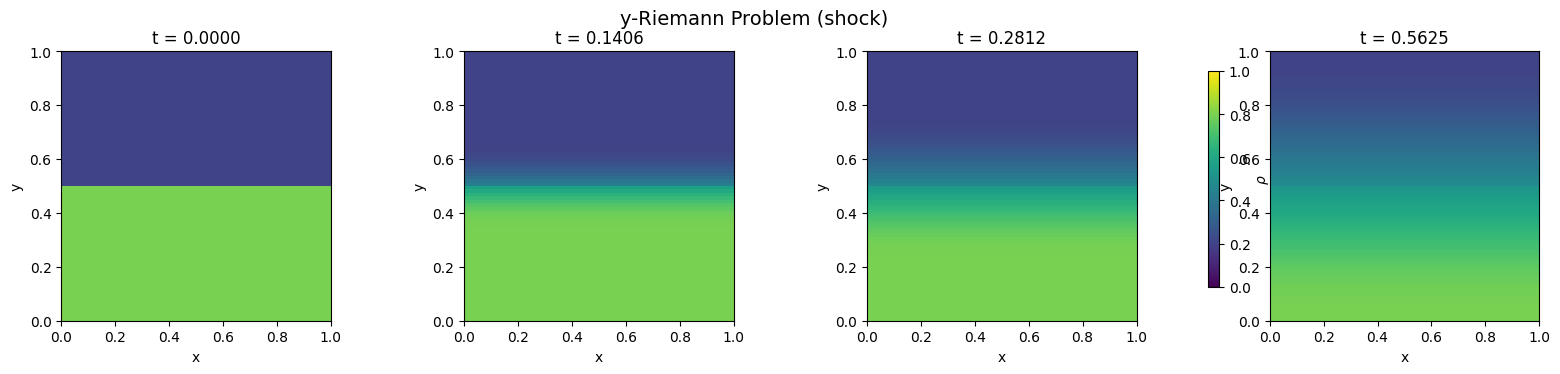

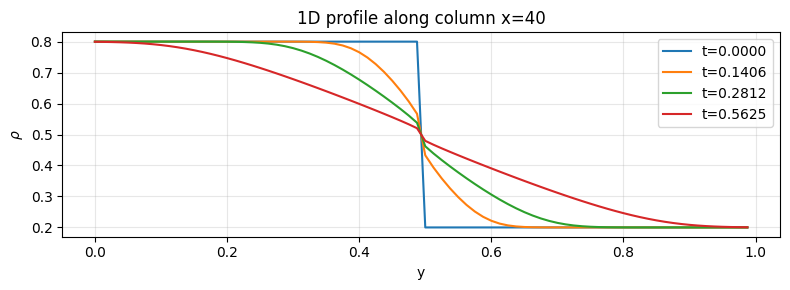

In [4]:
rho0_yr = riemann_y(x, y, rho_bottom=0.8, rho_top=0.2)
sol_yr = generate_one(rho0_yr, dx=DX, dy=DY, dt=DT, nt=NT, bc_type="zero_gradient")

plot_snapshots(
    sol_yr["rho"], sol_yr["x"], sol_yr["y"], sol_yr["t"], "y-Riemann Problem (shock)"
)

# Show the 1D profile: pick middle column
mid_col = NX // 2
fig, ax = plt.subplots(figsize=(8, 3))
for idx in [0, NT // 4, NT // 2, NT]:
    ax.plot(
        sol_yr["y"].numpy(),
        sol_yr["rho"][idx, :, mid_col].numpy(),
        label=f"t={sol_yr['t'][idx]:.4f}",
    )
ax.set_xlabel("y")
ax.set_ylabel(r"$\rho$")
ax.set_title(f"1D profile along column x={mid_col}")
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

## 4. Gaussian Bump

/tmp/ipykernel_34353/1719190479.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


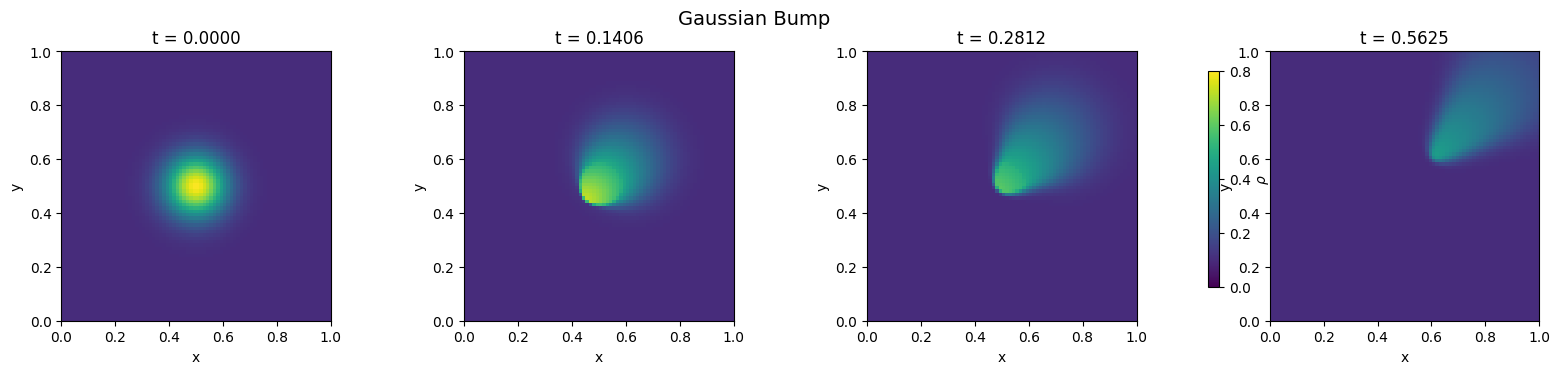

In [5]:
rho0_g = gaussian_bump(x, y, rho_bg=0.1, rho_peak=0.8, sigma=0.08)
sol_g = generate_one(rho0_g, dx=DX, dy=DY, dt=DT, nt=NT, bc_type="zero_gradient")

plot_snapshots(
    sol_g["rho"],
    sol_g["x"],
    sol_g["y"],
    sol_g["t"],
    "Gaussian Bump",
    vmin=0.0,
    vmax=0.8,
)

## 5. Boundary Condition Comparison

/tmp/ipykernel_34353/3394196910.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


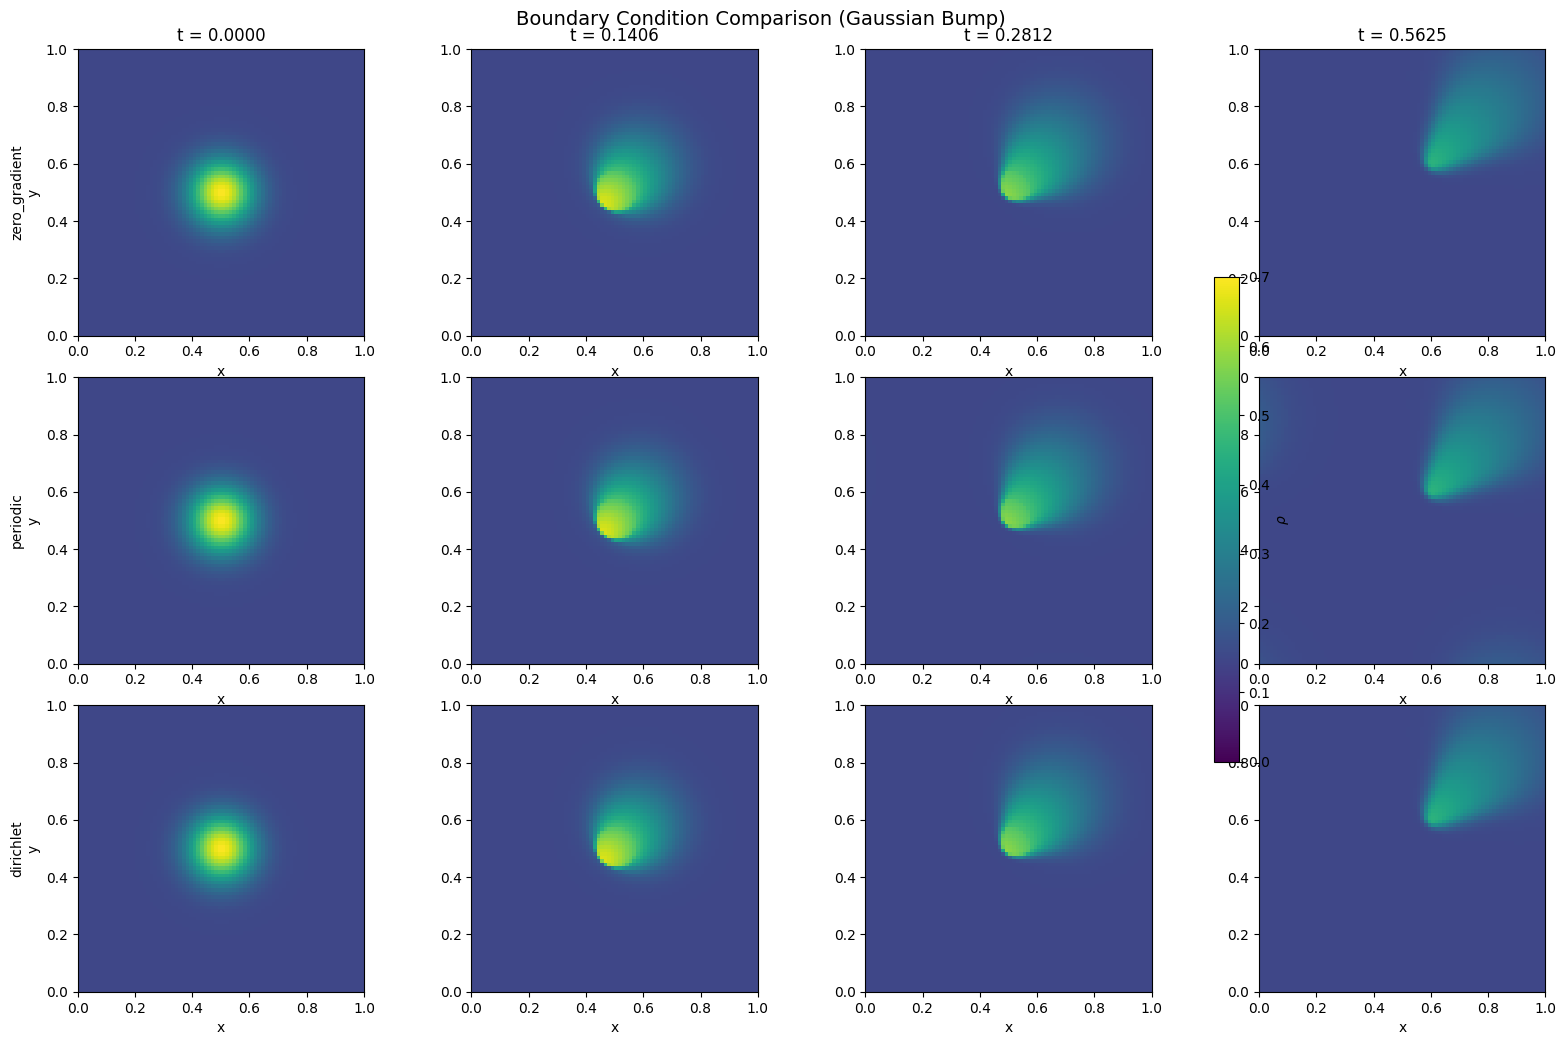

In [6]:
bc_types = ["zero_gradient", "periodic", "dirichlet"]
rho0_bc = gaussian_bump(x, y, rho_bg=0.15, rho_peak=0.7, sigma=0.08)

fig, axes = plt.subplots(len(bc_types), 4, figsize=(16, 3.5 * len(bc_types)))
snap_indices = [0, NT // 4, NT // 2, NT]

for row, bc in enumerate(bc_types):
    kwargs = dict(dx=DX, dy=DY, dt=DT, nt=NT, bc_type=bc)
    if bc == "dirichlet":
        kwargs["bc_value"] = 0.15
    sol_bc = generate_one(rho0_bc, **kwargs)
    norm = Normalize(vmin=0.0, vmax=0.7)
    for col, idx in enumerate(snap_indices):
        ax = axes[row, col]
        im = ax.imshow(
            sol_bc["rho"][idx].numpy(),
            origin="lower",
            extent=[x[0].item(), x[-1].item() + DX, y[0].item(), y[-1].item() + DY],
            cmap="viridis",
            norm=norm,
            aspect="equal",
        )
        if row == 0:
            ax.set_title(f"t = {sol_bc['t'][idx]:.4f}")
        if col == 0:
            ax.set_ylabel(f"{bc}\ny")
        else:
            ax.set_ylabel("")
        ax.set_xlabel("x")

fig.suptitle("Boundary Condition Comparison (Gaussian Bump)", fontsize=14)
fig.colorbar(im, ax=axes, shrink=0.6, label=r"$\rho$")
fig.tight_layout()
plt.show()

## 6. Anisotropic Speeds ($v_{\max,x} \neq v_{\max,y}$)

/tmp/ipykernel_34353/476014437.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


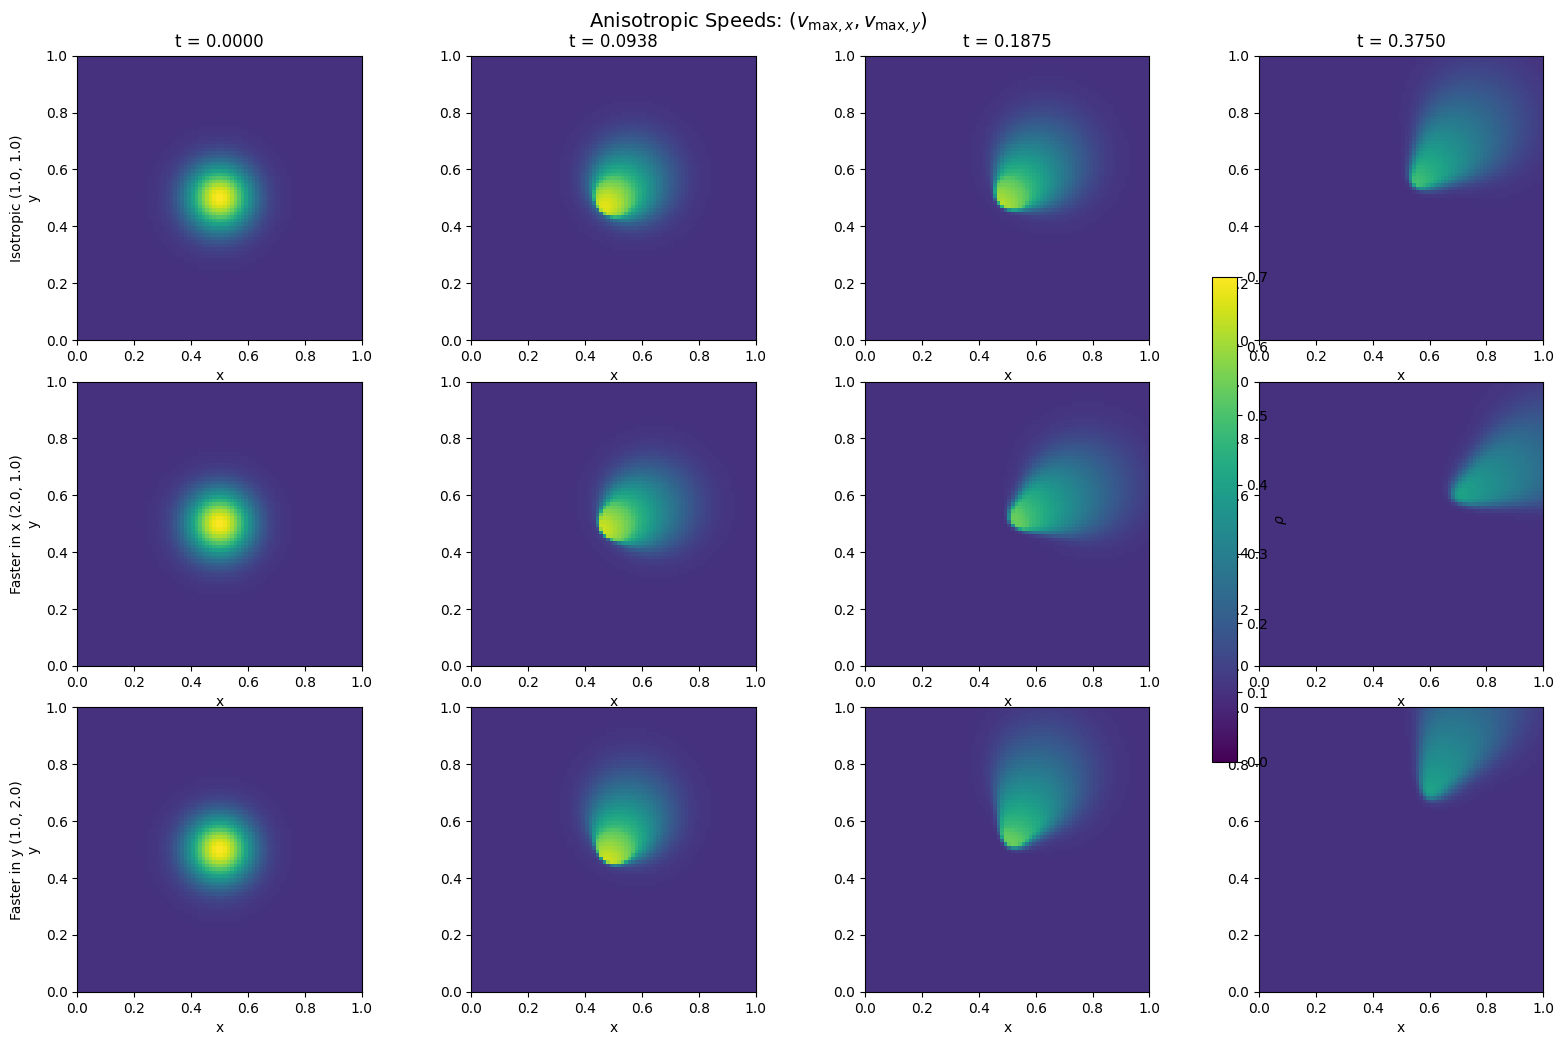

In [7]:
rho0_a = gaussian_bump(x, y, rho_bg=0.1, rho_peak=0.7, sigma=0.08)

# Use a safe dt for the fastest anisotropic case
dt_aniso = cfl_dt(DX, DY, 2.0, 1.0, cfl_number=0.45)

configs = [
    (1.0, 1.0, "Isotropic (1.0, 1.0)"),
    (2.0, 1.0, "Faster in x (2.0, 1.0)"),
    (1.0, 2.0, "Faster in y (1.0, 2.0)"),
]

fig, axes = plt.subplots(len(configs), 4, figsize=(16, 3.5 * len(configs)))
snap_indices = [0, NT // 4, NT // 2, NT]

for row, (vmx, vmy, label) in enumerate(configs):
    sol_a = generate_one(
        rho0_a,
        dx=DX,
        dy=DY,
        dt=dt_aniso,
        nt=NT,
        bc_type="zero_gradient",
        v_max_x=vmx,
        v_max_y=vmy,
    )
    norm = Normalize(vmin=0.0, vmax=0.7)
    for col, idx in enumerate(snap_indices):
        ax = axes[row, col]
        im = ax.imshow(
            sol_a["rho"][idx].numpy(),
            origin="lower",
            extent=[x[0].item(), x[-1].item() + DX, y[0].item(), y[-1].item() + DY],
            cmap="viridis",
            norm=norm,
            aspect="equal",
        )
        if row == 0:
            ax.set_title(f"t = {sol_a['t'][idx]:.4f}")
        if col == 0:
            ax.set_ylabel(f"{label}\ny")
        else:
            ax.set_ylabel("")
        ax.set_xlabel("x")

fig.suptitle(r"Anisotropic Speeds: $(v_{\max,x}, v_{\max,y})$", fontsize=14)
fig.colorbar(im, ax=axes, shrink=0.6, label=r"$\rho$")
fig.tight_layout()
plt.show()

## 7. Batch Generation (`generate_n`)

LWR2D samples: 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]
/tmp/ipykernel_34353/619131841.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


rho shape: torch.Size([6, 201, 80, 80])
x   shape: torch.Size([80])
y   shape: torch.Size([80])
t   shape: torch.Size([201])


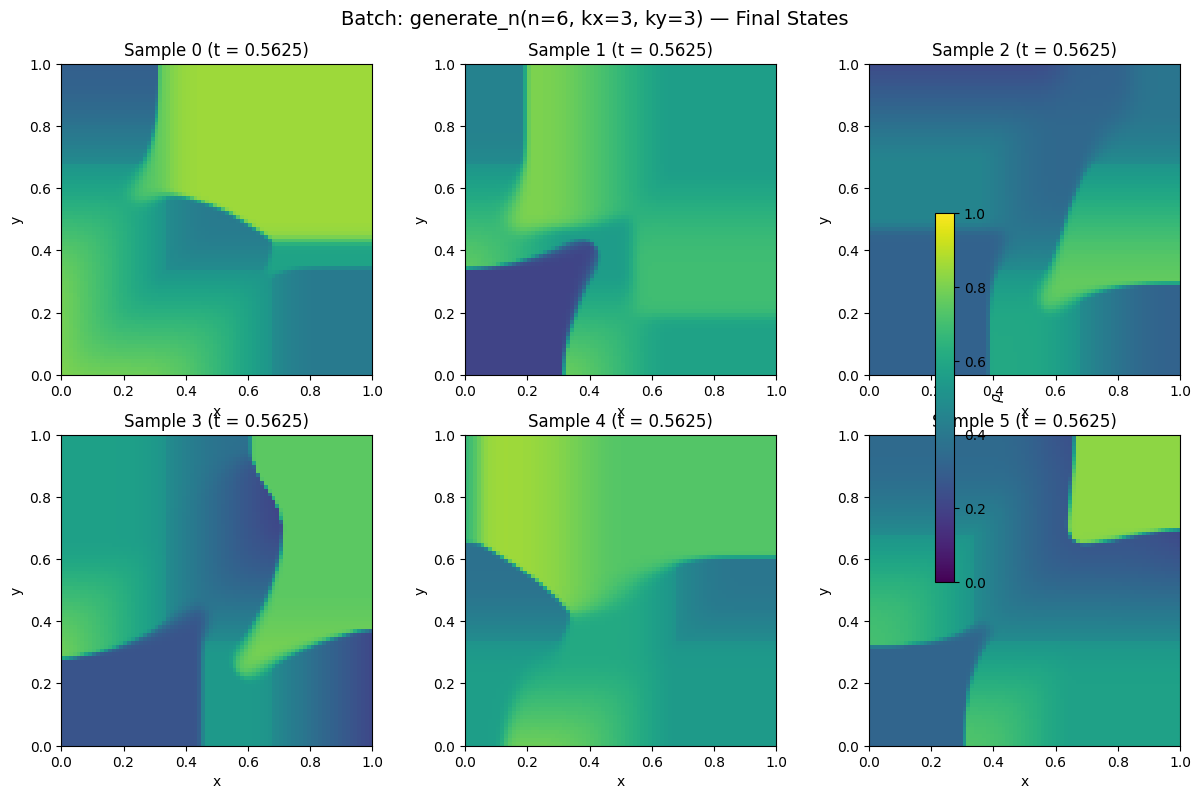

In [8]:
batch = generate_n(
    n=6,
    kx=3,
    ky=3,
    nx=NX,
    ny=NY,
    dx=DX,
    dy=DY,
    dt=DT,
    nt=NT,
    seed=42,
)

print(f"rho shape: {batch['rho'].shape}")
print(f"x   shape: {batch['x'].shape}")
print(f"y   shape: {batch['y'].shape}")
print(f"t   shape: {batch['t'].shape}")

# Plot final state of each sample
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(
        batch["rho"][i, -1].numpy(),
        origin="lower",
        extent=[x[0].item(), x[-1].item() + DX, y[0].item(), y[-1].item() + DY],
        cmap="viridis",
        vmin=0.0,
        vmax=1.0,
        aspect="equal",
    )
    ax.set_title(f"Sample {i} (t = {batch['t'][-1]:.4f})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

fig.suptitle("Batch: generate_n(n=6, kx=3, ky=3) — Final States", fontsize=14)
fig.colorbar(im, ax=axes, shrink=0.6, label=r"$\rho$")
fig.tight_layout()
plt.show()

## 8. Greenshields Flux and CFL

The 2D LWR model uses the Greenshields flux:
$$f(\rho) = v_{\max} \, \rho \left(1 - \frac{\rho}{\rho_{\max}}\right)$$

with characteristic speed $f'(\rho) = v_{\max} \left(1 - \frac{2\rho}{\rho_{\max}}\right)$.

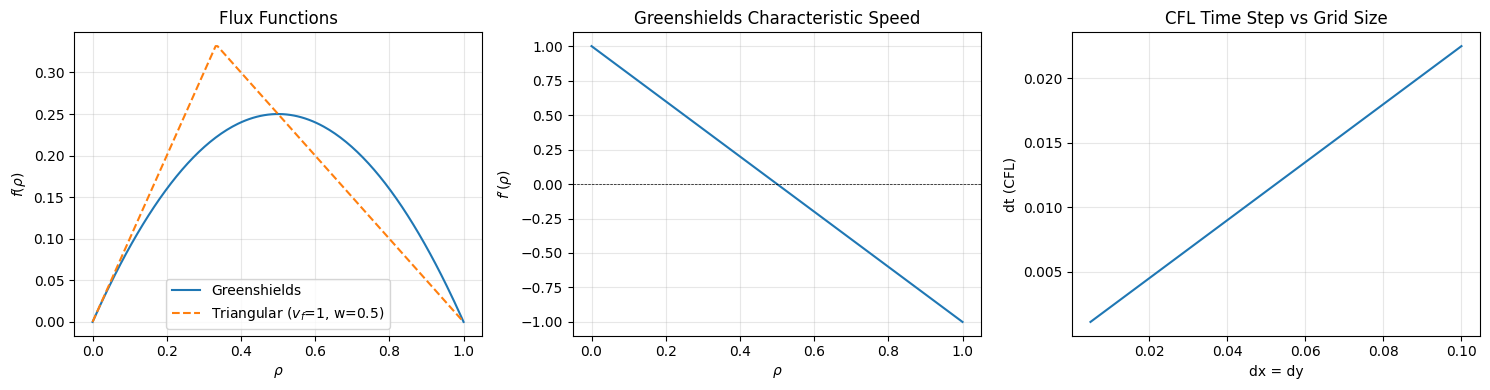

Shock speed (rho_L=0.8, rho_R=0.2): s = -0.0000
  = 1 - rho_L - rho_R = -0.0000


In [9]:
rho_np = np.linspace(0, 1, 200)
rho_t = torch.tensor(rho_np, dtype=torch.float32)

flux_gs = greenshields_flux(rho_t, v_max=1.0, rho_max=1.0).numpy()
dflux_gs = greenshields_derivative(rho_t, v_max=1.0, rho_max=1.0).numpy()
flux_tri = triangular_flux(rho_t, v_f=1.0, w=0.5, rho_max=1.0).numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(rho_np, flux_gs, label="Greenshields")
axes[0].plot(rho_np, flux_tri, label="Triangular ($v_f$=1, w=0.5)", linestyle="--")
axes[0].set_xlabel(r"$\rho$")
axes[0].set_ylabel(r"$f(\rho)$")
axes[0].set_title("Flux Functions")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(rho_np, dflux_gs)
axes[1].axhline(0, color="k", linewidth=0.5, linestyle="--")
axes[1].set_xlabel(r"$\rho$")
axes[1].set_ylabel(r"$f'(\rho)$")
axes[1].set_title(r"Greenshields Characteristic Speed")
axes[1].grid(True, alpha=0.3)

# CFL dt vs grid size
dxs = np.linspace(0.005, 0.1, 50)
dts = [cfl_dt(d, d, 1.0, 1.0, 0.45) for d in dxs]
axes[2].plot(dxs, dts)
axes[2].set_xlabel("dx = dy")
axes[2].set_ylabel("dt (CFL)")
axes[2].set_title("CFL Time Step vs Grid Size")
axes[2].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

# Rankine-Hugoniot check
rho_L, rho_R = 0.8, 0.2
fL = rho_L * (1 - rho_L)
fR = rho_R * (1 - rho_R)
shock_speed = (fR - fL) / (rho_R - rho_L)
print(f"Shock speed (rho_L={rho_L}, rho_R={rho_R}): s = {shock_speed:.4f}")
print(f"  = 1 - rho_L - rho_R = {1 - rho_L - rho_R:.4f}")

## 9. Mass Conservation Check

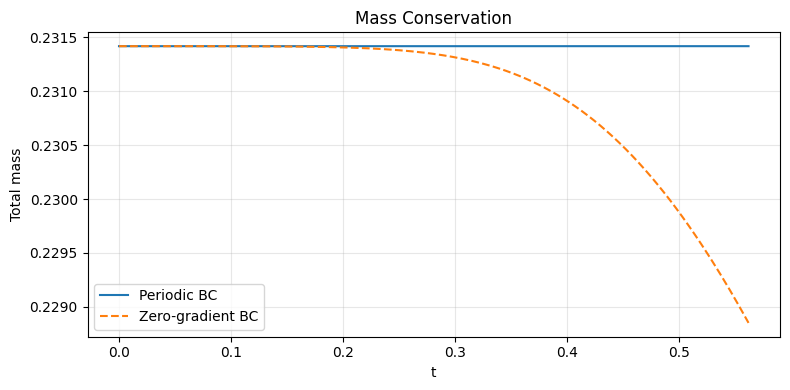

Periodic  — initial: 0.231416, final: 0.231416, rel error: 3.22e-07
Zero-grad — initial: 0.231416, final: 0.228852


In [10]:
rho0_mc = gaussian_bump(x, y, rho_bg=0.2, rho_peak=0.7, sigma=0.1)

sol_periodic = generate_one(rho0_mc, dx=DX, dy=DY, dt=DT, nt=NT, bc_type="periodic")
sol_zg = generate_one(rho0_mc, dx=DX, dy=DY, dt=DT, nt=NT, bc_type="zero_gradient")

mass_periodic = sol_periodic["rho"].sum(dim=(-2, -1)).numpy() * DX * DY
mass_zg = sol_zg["rho"].sum(dim=(-2, -1)).numpy() * DX * DY
t_arr = sol_periodic["t"].numpy()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t_arr, mass_periodic, label="Periodic BC")
ax.plot(t_arr, mass_zg, label="Zero-gradient BC", linestyle="--")
ax.set_xlabel("t")
ax.set_ylabel("Total mass")
ax.set_title("Mass Conservation")
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

print(
    f"Periodic  — initial: {mass_periodic[0]:.6f}, final: {mass_periodic[-1]:.6f}, "
    f"rel error: {abs(mass_periodic[-1] - mass_periodic[0]) / mass_periodic[0]:.2e}"
)
print(f"Zero-grad — initial: {mass_zg[0]:.6f}, final: {mass_zg[-1]:.6f}")